In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [43]:
data_ready = pd.read_csv("data_ready.csv")

In [44]:
data_ready[data_ready.select_dtypes(include=['float64']).columns] = data_ready.select_dtypes(include=['float64']).astype("float32")

In [45]:
data_ready = data_ready.sample(frac=1)

In [46]:
# 70% training data, 15% validation, 15% test
train_dev, test = train_test_split(data_ready, test_size=0.15, random_state=42)
train, dev = train_test_split(train_dev, test_size=0.176, random_state=42)

In [14]:
# # Step 1: Separate majority and minority classes
# minority_class = train[train['5YR_SURV'] == 0]  # Adjust the condition based on your class labels
# majority_class = train[train['5YR_SURV'] == 1]

# # Step 2: Duplicate (oversample) the minority class
# oversample_minority = minority_class.sample(n=len(majority_class), replace=True)

# # Step 3: Combine the majority class with the oversampled minority class
# balanced_df = pd.concat([majority_class, oversample_minority])

# # Shuffle the dataset to mix up the rows
# train = balanced_df.sample(frac=1).reset_index(drop=True)

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

# Assuming you have a dataset with X (features) and y (target)
# X, y = load_your_data()

# Split into minority and majority classes
X_minority = train[train["5YR_SURV"] == 0].copy()  # Rare class
X_majority = train[train["5YR_SURV"] == 1].copy()  # Abundant class

col = ["5YR_SURV"]
X_minority = X_minority.drop(col, axis=1)
X_majority = X_majority.drop(col, axis=1)
# Define number of models (n) for ensembling
n_models = 10
n_majority_samples = 1000  # Number of majority samples per model
models = []

# Train n models with subsets of the majority class
for i in range(n_models):
    # Randomly sample from the majority class without replacement
    X_majority_sample = resample(X_majority, n_samples=n_majority_samples, replace=False, random_state=i)

    # Combine with minority class
    X_train = pd.concat([X_minority, X_majority_sample])
    y_train = np.hstack((np.zeros(len(X_minority)), np.ones(len(X_majority_sample))))

    # Split into train/test sets
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=i)

    # Train a model (using Random Forest as an example)
    model = RandomForestClassifier(random_state=i)
    model.fit(X_train_split, y_train_split)

    # Store model
    models.append(model)

# Ensemble predictions
def ensemble_predict(X_test, models):
    # Get predictions from each model
    predictions = np.zeros((len(models), len(X_test)))
    for i, model in enumerate(models):
        predictions[i, :] = model.predict(X_test)
    
    # Majority voting (for classification)
    final_predictions = np.round(np.mean(predictions, axis=0))  # Round average predictions
    return final_predictions

# Test the ensemble model
y_pred_ensemble = ensemble_predict(X_test_split, models)

# Evaluate accuracy
print(f"Ensemble accuracy: {accuracy_score(y_test_split, y_pred_ensemble)}")


Ensemble accuracy: 0.8065661047027507


In [15]:
# convert to tensors and extract labels

train_label = train.pop("5YR_SURV")
dev_label = dev.pop("5YR_SURV")
test_label = test.pop("5YR_SURV")

train_tf = tf.convert_to_tensor(train)
dev_tf = tf.convert_to_tensor(dev)
test_tf = tf.convert_to_tensor(test)

train_label_tf = tf.convert_to_tensor(train_label)
dev_label_tf = tf.convert_to_tensor(dev_label)
test_label_tf = tf.convert_to_tensor(test_label)

In [16]:
from tensorflow.keras.initializers import GlorotUniform

In [17]:
model = tf.keras.Sequential(
    [
       tf.keras.Input(shape=(214,)),
       tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L1"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L3"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L15"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L5"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L9"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L11"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(1, activation="sigmoid", name="L13") 
    ]
)

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [20]:
from sklearn.utils import class_weight
y_train = np.array(train_label_tf)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the class weights into a dictionary with class labels as keys
class_weight_dict = dict(enumerate(class_weights))

In [22]:
history = model.fit(train_tf, train_label_tf, epochs=3000, batch_size=128, callbacks=[early_stopping], class_weight=class_weight_dict,validation_data = (dev_tf, dev_label_tf))

Epoch 1/3000
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4993 - auc: 0.5035 - loss: 56.5788 - recall: 0.4918 - val_accuracy: 0.3060 - val_auc: 0.5144 - val_loss: 55.7783 - val_recall: 0.0614
Epoch 2/3000
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5091 - auc: 0.5112 - loss: 55.8578 - recall: 0.4946 - val_accuracy: 0.4112 - val_auc: 0.5225 - val_loss: 55.0994 - val_recall: 0.2883
Epoch 3/3000
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5096 - auc: 0.5152 - loss: 55.1876 - recall: 0.4903 - val_accuracy: 0.4742 - val_auc: 0.5301 - val_loss: 54.3952 - val_recall: 0.4243
Epoch 4/3000
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5146 - auc: 0.5224 - loss: 54.4908 - recall: 0.4990 - val_accuracy: 0.4915 - val_auc: 0.5345 - val_loss: 53.7151 - val_recall: 0.4590
Epoch 5/3000
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5222 - auc: 0.5246 - loss: 53.8170 - recall: 0.5039 - val_accuracy: 0.5046 - val_auc: 0.5392 - val_loss: 53.0423 - val_

KeyboardInterrupt: 

In [31]:
from sklearn.metrics import classification_report, roc_auc_score

# y_pred = model.predict(X_resampled)
# y_pred = y_pred.round()
# print("Classification Report:")
print(classification_report(dev_label_tf, y_pred))
# print("ROC AUC Score:", roc_auc_score(dev_label_tf, y_pred))

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score


y_pred = model.predict(dev_tf)
y_pred = y_pred.round()

precision = precision_score(dev_label_tf, y_pred)
recall = recall_score(dev_label_tf, y_pred)
f1 = f1_score(dev_label_tf, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
recall_score(dev_label_tf, y_pred, pos_label=0)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Precision: 0.78
Recall: 0.58
F1-Score: 0.67


0.5630165289256198

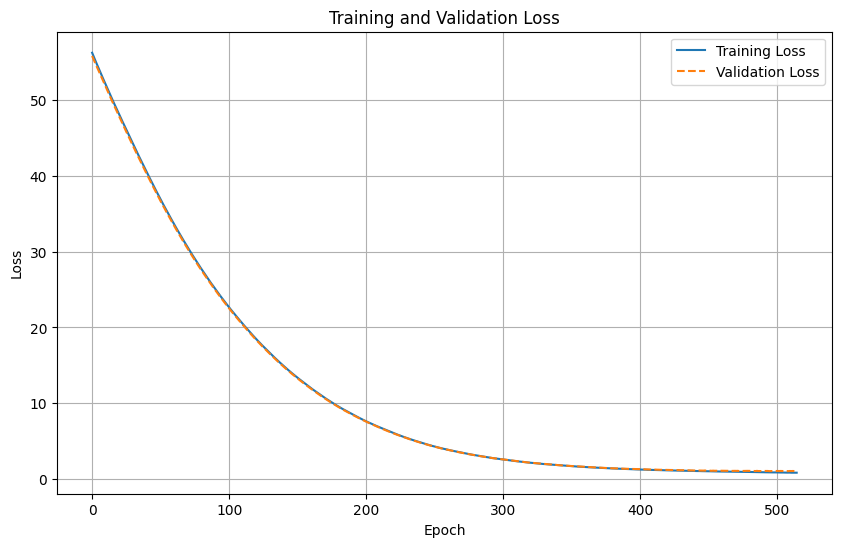

In [16]:
loss_values = history.history['loss']
val_loss_values = history.history.get('val_loss')

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
if val_loss_values:
    plt.plot(val_loss_values, label='Validation Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
model.evaluate(dev_tf, dev_label_tf)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5644 - auc: 0.6007 - loss: 1.0429 - recall: 0.5658


[1.0337666273117065,
 0.5785216093063354,
 0.5842567682266235,
 0.6086810827255249]

In [24]:
from xgboost import XGBClassifier

In [41]:
model = XGBClassifier(n_estimators=500, max_depth=6, subsample=0.6, colsample_bytree=0.6, learning_rate=0.1, reg_alpha=0.1, reg_lambda=1.0, scale_pos_weight=0.3, objective='binary:logistic')
model.fit(train_tf, train_label_tf)
print(model.score(train_tf, train_label_tf))
print(model.score(dev_tf, dev_label_tf))
y_pred = model.predict(dev_tf)

0.9634110005363209
0.6566248256624826


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

precision = precision_score(dev_label_tf, y_pred)
recall = recall_score(dev_label_tf, y_pred)
f1 = f1_score(dev_label_tf, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(classification_report(dev_label_tf, y_pred))


Precision: 0.73
Recall: 0.97
F1-Score: 0.84
              precision    recall  f1-score   support

         0.0       0.52      0.07      0.13       997
         1.0       0.73      0.97      0.84      2588

    accuracy                           0.72      3585
   macro avg       0.63      0.52      0.48      3585
weighted avg       0.67      0.72      0.64      3585



In [21]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'reg_alpha': [0.01, 0.1, 1],
#     'reg_lambda': [0.01, 0.1, 1]
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
# grid_search.fit(np.array(train_tf), np.array(train_label_tf))

# print(f"Best Hyperparameters: {grid_search.best_params_}")
# print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")


In [22]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier

# model = LogisticRegression(max_iter=1000)
# model.fit(train_tf, train_label_tf)
# print(f"Logistic Regression Accuracy: {model.score(dev_tf, dev_label_tf) * 100:.2f}%")

# model = RandomForestClassifier(n_estimators=100)
# model.fit(train_tf, train_label_tf)
# print(f"Random Forest Accuracy: {model.score(dev_tf, dev_label_tf) * 100:.2f}%")
# model.predict(dev_tf)


# precision = precision_score(dev_label_tf, y_pred)
# recall = recall_score(dev_label_tf, y_pred)
# f1 = f1_score(dev_label_tf, y_pred)

# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")
# from sklearn.metrics import recall_score
# recall_score(dev_label_tf, y_pred, pos_label=0)

In [8]:
from sklearn.svm import SVC

# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(train_tf, train_label_tf)

svc_predict = svc_model.predict(train_tf)# check performance
print('ROCAUC score:',roc_auc_score(train_label_tf, svc_predict))
print('Accuracy score:',accuracy_score(train_label_tf, svc_predict))
print('F1 score:',f1_score(train_label_tf, svc_predict))

ROCAUC score: 0.6952966710133466
Accuracy score: 0.7006137894046839
F1 score: 0.7735304724125496
